In [ ]:
import os
#CHANGE THIS to aboslute path of Caltech repo
os.chdir('/Users/nasifimtiaz/Desktop/Caltech256-project')
#this is a global variable to set how many subset of classes we will work with 
#CHANGE THIS TO REQUIRED NUMBER (257) while running on GPU
working_classes=10

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

#images are in different shapes. needs to square them.
def shrink_square(img, shrink_size, color_mode, fill_color):
    #all the images will be shrinked to shrink_size with any leftover filled with color_fill
    ## thumbnail resizes image while maintaining aspect ratio
    shrinked_img=img.thumbnail((shrink_size,shrink_size),Image.ANTIALIAS)
    
    #if some images were originally less than shrink_size, bring to shrink size by filling the leftover
    output=Image.new(color_mode,(shrink_size,shrink_size),fill_color)
    output.paste(img, (int((shrink_size - img.size[0]) / 2), int((shrink_size - img.size[1]) / 2)))
    
    return output


#turn images to np_array
def image_to_tensors(img):
    arr=np.array(img)
    return arr

        

In [ ]:
#globally setting up the square size that all images will be resized to
img_size=128

In [ ]:
hm={}
path='./256_ObjectCategories'
folders=os.listdir(path)


for folder in folders:
    os.chdir(path+'/'+folder)
    image_paths=os.listdir()
    class_images=[]
    for i in image_paths:
        if i[-4:]=='.jpg':
            print("processing ",i)
            img=Image.open(i)
            shrinked_img=shrink_square(img, img_size, 'RGB', 0)
            img_arr=image_to_tensors(shrinked_img)
            img_arr=img_arr/255 #scaling pixel values to [0,1]
            class_images.append(img_arr)
            img.close()
            shrinked_img.close()
    class_name= folder.split('.')[1]
    hm[class_name]=class_images
    os.chdir('../..')


In [ ]:
print("total classes: ", len(hm))
sum=0
flawed=0
class_freqs=[]
for k in hm.keys():
    sum+=len(hm[k])
    class_freqs.append(len(hm[k]))
    for i in hm[k]:
        if i.shape != (img_size,img_size,3):
            flawed+=1
print("total images: ",sum)
print("flawd images: ", flawed)

In [ ]:
#visualize frequency per class categories
classes=hm.keys()
y_pos=np.arange(len(classes))
plt.figure(figsize=(20,5))
plt.bar(y_pos,class_freqs,align='center', alpha=1)
plt.xticks(y_pos,classes,rotation=90)
plt.ylabel('# of images')
plt.title('Image number per classes. While few classes have higher images, most has around 100 images')
plt.show()




In [ ]:
#convert hm to X,y data mapping
#where each row of X is an image, y is it's class in int
import random
def make_Xy(hm, subset_classes):
    classes=list(hm.keys())
    random.shuffle(classes)
    classes=classes[0:subset_classes]
    X=[]
    y=[]
    for key in classes:
        images=hm[key]
        X.extend(images)
        y.extend([key]*len(images))
    X=np.array(X)
    y=pd.get_dummies(y)
    
    return X,y     

In [ ]:
X,y=make_Xy(hm,subset_classes=working_classes)
#make a test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.20)

In [ ]:
print(y_train.shape)
print(X_train.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras.backend as K
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras.backend as K
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D,Flatten

In [ ]:
def DenseNetwork(X_train,y_train,input_dim,output_classes,
                 hidden_layer=2,units=[2048,2048], kernel_initializer='RandomNormal', 
                 hidden_layer_activation='relu',output_layer_activation='softmax', 
                 loss='categorical_crossentropy',metrics=['accuracy'],learning_rate=.1,
                 dropout=.5,batch_size=64,epochs=10,validation_split=.2):
    
    #flatten the images first for dense network
    X_train=X_train.reshape(X_train.shape[0],-1)
    
    model= Sequential()
    
    for i in range(0,hidden_layer):
        model.add(Dense(units=units[0],kernel_initializer=kernel_initializer,input_dim=input_dim))
        model.add(BatchNormalization())
        model.add(Activation(hidden_layer_activation))
        model.add(Dropout(dropout))


    model.add(Dense(output_classes,kernel_initializer=kernel_initializer,activation=output_layer_activation))
    model.compile(Adam(lr=learning_rate),loss=loss,metrics=metrics)

    fit=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=validation_split)
    
    return model, fit


In [ ]:
def validation_plots(history, prefix):
    training_loss = history['loss']
    validation_loss = history['val_loss']
    accuracy = history['accuracy']
    val_accuracy=history['val_accuracy']
    epochs=range(1,len(accuracy)+1)
    
    plt.plot(epochs,training_loss,'bo',label='Training loss')
    plt.plot(epochs,validation_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig(prefix + '_1.png')
    plt.clf()
    
    plt.plot(epochs,accuracy,'b',label='Training accuracy')
    plt.plot(epochs,val_accuracy,'r',label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.savefig(prefix + '_2.png')
    plt.clf()

In [ ]:
dense_model, dense_fit = DenseNetwork(X_train,y_train,img_size*img_size*3,working_classes,epochs=10,batch_size=32)
validation_plots(dense_fit.history,"ANN")
print(dense_model.evaluate(X_test.reshape(X_test.shape[0],-1),y_test))

In [126]:
def CNN(X_train,y_train,input_dim,output_classes,
        total_layers=3, filters=32, learning_rate=.01, kernel_size=(3,3),
        epochs=80, batch_size=32,validation_split=.2):
    decay=batch_size/epochs 
    optimizer = Adam(lr=learning_rate,decay=decay)
    model = Sequential()
    model.add(Conv2D(filters = (filters), kernel_size= kernel_size, input_shape = input_dim, padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size = (2,2)))

    for i in range(total_layers):
        fltr = filters * (2**(i+1))
        model.add(Conv2D(filters = fltr, kernel_size= kernel_size, padding = 'same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size = (2,2)))
     
    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 

    model.add(Dense(output_classes,activation='softmax'))
    model.compile(optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    fit = model.fit_generator(ImageDataGenerator().flow(X_train, y_train.values, batch_size=batch_size), epochs=epochs, verbose=1)
    
    return model,fit

In [127]:
cnn_model, cnn_fit = CNN(X_train,y_train,(img_size,img_size,3),working_classes,epochs=10,batch_size=32)

Epoch 1/10
29/29 [==============================] - 29s 988ms/step - loss: 2.4349 - accuracy: 0.3784
Epoch 2/10
29/29 [==============================] - 27s 930ms/step - loss: 1.5055 - accuracy: 0.5490
Epoch 3/10
29/29 [==============================] - 28s 951ms/step - loss: 1.3242 - accuracy: 0.5875
Epoch 4/10
29/29 [==============================] - 28s 955ms/step - loss: 1.2160 - accuracy: 0.6183
Epoch 5/10
29/29 [==============================] - 28s 953ms/step - loss: 1.1282 - accuracy: 0.6392
Epoch 6/10
29/29 [==============================] - 26s 902ms/step - loss: 1.1033 - accuracy: 0.6502
Epoch 7/10
29/29 [==============================] - 26s 882ms/step - loss: 1.0589 - accuracy: 0.6722
Epoch 8/10
29/29 [==============================] - 29s 998ms/step - loss: 1.0362 - accuracy: 0.6711
Epoch 9/10
29/29 [==============================] - 27s 932ms/step - loss: 0.9563 - accuracy: 0.6898
Epoch 10/10
29/29 [==============================] - 29s 985ms/step - loss: 0.9472 - accura

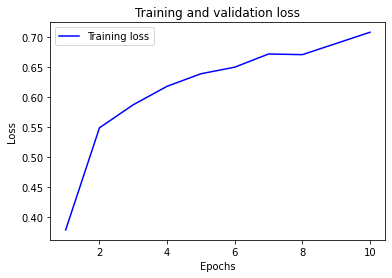

NameError: name 'prefix' is not defined

In [130]:
history=cnn_fit.history
loss = history['loss']
accuracy = history['accuracy']
epochs=range(1,len(accuracy)+1)

plt.plot(epochs,accuracy,'b',label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig(prefix + '_1.png')
plt.clf()